# Probing Combined Approach   


In this section we will investigate the combined approach of both models introduced in the paper, the traditional logistic regression and the newly proposed distilbert fine tuned on the medical data. To decrease redundancy, the trained models have been exported and will be imported in this section to prevent duplicate training processes.  

## Loading Logistical Regression

In [123]:
import pandas as pd

lr_df = pd.read_csv("logistic_regression_test_predicted.csv")
lr_df = lr_df[["sequential identifier", "predicted_label"]]
lr_df = lr_df.rename(columns={"predicted_label": "predicted_sensitivity"})
lr_df

,sequential identifier,predicted_sensitivity
0,126,0
1,154,1
2,223,1
3,283,0
4,300,0
...,...,...
14425,348393,0
14426,348400,0
14427,348498,1
14428,348532,0


## Loading DistilBert 

To reduce computational complexity when running the model, we have precomputed the results of inference in a csv and will therefore load the results from a csv instead of performing real-time inference. 

In [124]:
bert_df = pd.read_csv("sensitivity_predictions_comparison.csv")
bert_df
bert_df = bert_df[["sequential identifier", "predicted_sensitivity"]]
bert_df.head()

,sequential identifier,predicted_sensitivity
0,126,0
1,154,1
2,223,1
3,283,0
4,300,0


## Compute Combinded Sensitivity

In [133]:
# merge bert with logistical regression on identifier
merge_on = "sequential identifier" 
df_combined = bert_df.merge(lr_df, on=merge_on, suffixes=("_bert", "_lr"))



p_bert = df_combined["predicted_sensitivity_bert"]  
p_lr = df_combined["predicted_sensitivity_lr"]


# Compute combined probability
df_combined["predicted_sensitivity_combined"] = 1 - (1 - p_lr) * (1 - p_bert)
print(df_combined)


       sequential identifier  predicted_sensitivity_bert  \
0                        126                           0   
1                        154                           1   
2                        223                           1   
3                        283                           0   
4                        300                           0   
...                      ...                         ...   
14425                 348393                           0   
14426                 348400                           0   
14427                 348498                           1   
14428                 348532                           0   
14429                 348535                           0   

       predicted_sensitivity_lr  predicted_sensitivity_combined  
0                             0                               0  
1                             1                               1  
2                             1                               1  
3              

## Inference Function

In [126]:
import pandas as pd
import numpy as np

def predict_labels(x_test, df_combined, id_column="sequential identifier", threshold=0.5):
    
    if not isinstance(x_test, pd.Series):
        raise ValueError("x_test must be a Pandas Series containing the titles/abstracts.")

    x_test = x_test.astype(int)
    df_combined[id_column] = df_combined[id_column].astype(int)

    df_test_probs = df_combined[df_combined[id_column].isin(x_test)]
   
    print(df_test_probs)

    # Check if any matches were found
    if df_test_probs.empty:
        print("No matches found in df_combined for sequential identifier in x_test.")
    
    # Apply threshold for final prediction
    y_pred = (df_test_probs["predicted_sensitivity_combined"] >= threshold).astype(int)

    return y_pred


## Load data

In [92]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def parse_ohsumed_file(file_path):
    """Parses an OHSUMED file into a DataFrame with proper column names."""
    documents = []
    document = {}

    # Read the file line by line
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()  # Remove extra whitespace

            if line.startswith(".I"):  # New document identifier
                if document:  # If there's an existing document, save it
                    documents.append(document)
                document = {"sequential identifier": line[3:]}  # Initialize a new document

            elif line.startswith(".U"):  # MEDLINE identifier
                document["MEDLINE identifier"] = next(f).strip()

            elif line.startswith(".S"):  # Source
                document["source"] = next(f).strip()

            elif line.startswith(".M"):  # MeSH terms
                document["mesh_terms"] = next(f).strip()

            elif line.startswith(".T"):  # Title
                document["title"] = next(f).strip()

            elif line.startswith(".P"):  # Publication type
                document["publication type"] = next(f).strip()

            elif line.startswith(".W"):  # Abstract
                document["abstract"] = next(f).strip()

            elif line.startswith(".A"):  # Author
                document["author"] = next(f).strip()

    # Add the last document if it exists
    if document:
        documents.append(document)

    # Convert the list of documents into a DataFrame
    return pd.DataFrame(documents)

# File paths for individual files
file_87_path = "./data/ohsumed.87.txt"
file_88_path = "./data/ohsumed.88.txt"
file_89_path = "./data/ohsumed.89.txt"
file_90_path = "./data/ohsumed.90.txt"
file_91_path = "./data/ohsumed.91.txt"

# Parse each file into its own DataFrame
df_ohsumed_87 = parse_ohsumed_file(file_87_path)
df_ohsumed_88 = parse_ohsumed_file(file_88_path)
df_ohsumed_89 = parse_ohsumed_file(file_89_path)
df_ohsumed_90 = parse_ohsumed_file(file_90_path)
df_ohsumed_91 = parse_ohsumed_file(file_91_path)

In [24]:
# Combine all DataFrames into a single DataFrame
ohsumed_combined_df = pd.concat([df_ohsumed_87, df_ohsumed_88, df_ohsumed_89, df_ohsumed_90, df_ohsumed_91], ignore_index=True)

# Print the combined DataFrame's shape (rows and columns). Should be: 348566
print(f"Combined DataFrame shape: {ohsumed_combined_df.shape}")

# Display the first few rows of the combined DataFrame
print(ohsumed_combined_df.head())

Combined DataFrame shape: (348566, 8)
  sequential identifier MEDLINE identifier                             source  \
0                     1           87049087    Am J Emerg Med 8703; 4(6):491-5   
1                     2           87049088  Am J Emerg Med 8703; 4(6):496-500   
2                     3           87049089    Am J Emerg Med 8703; 4(6):501-3   
3                     4           87049090    Am J Emerg Med 8703; 4(6):504-6   
4                     5           87049092    Am J Emerg Med 8703; 4(6):511-3   

                                          mesh_terms  \
0  Allied Health Personnel/*; Electric Countersho...   
1  Antidepressive Agents, Tricyclic/*PO; Arrhythm...   
2  Adult; Aircraft/*; Altitude/*; Blood Gas Monit...   
3  Adolescence; Adult; Aged; Blood Glucose/*ME; D...   
4  Aged; Aged, 80 and over; Case Report; Female; ...   

                                               title  publication type  \
0  Refibrillation managed by EMT-Ds: incidence an...  JOURNAL AR

In [25]:
# Load the judged file (relevance labeles)
judged_df = pd.read_csv("./data/judged.txt", sep="\t", header=None,
                        names=["Query", "Document-UI", "Document-Index", "Relevance1", "Relevance2", "Relevance3"])

print(f"Loaded judged file with {len(judged_df)} rows")
judged_df.head()

# Get unique documents
unique_docs = judged_df['Document-UI'].nunique()
judged_df = judged_df.drop_duplicates(subset=['Document-UI'], keep='first')

print(f"Unique documents: {unique_docs}")
print(f"New df size: {len(judged_df)}")

judged_df.head()

Loaded judged file with 16140 rows
Unique documents: 14430
New df size: 14430


,Query,Document-UI,Document-Index,Relevance1,Relevance2,Relevance3
0,1,87097544,40626,d,NaN,d
1,1,87153566,11852,n,NaN,n
2,1,87157536,12693,d,NaN,NaN
3,1,87157537,12694,d,NaN,NaN
4,1,87184723,15450,n,NaN,NaN


In [26]:
judged_df.rename(columns={"Document-UI": "MEDLINE identifier"}, inplace=True)

# Converting key to string
ohsumed_combined_df["MEDLINE identifier"] = ohsumed_combined_df["MEDLINE identifier"].astype(int)
judged_df["MEDLINE identifier"] = judged_df["MEDLINE identifier"].astype(int)
judged_df["is_relevant_ind"] = 1

# Perform the left join
merged_df = ohsumed_combined_df.merge(judged_df, on="MEDLINE identifier", how="left")

# Display the resulting DataFrame
print(f"Resulting DataFrame shape: {merged_df.shape}")
print(merged_df.head())

# Create a new column Relevance_total based on the rules that can be kept showing relevance for all three relevance columns
merged_df["Relevance_total"] = np.where(
    ~merged_df["Relevance1"].isna(),  # If Relevance1 is not NaN, take it
    merged_df["Relevance1"],
    np.where(
        ~merged_df["Relevance2"].isna(),  # Else if Relevance2 is not NaN, take it
        merged_df["Relevance2"],
        merged_df["Relevance3"]  # Else take Relevance3
    )
)
merged_df.head(10000)

# Drop the specified columns
columns_to_drop = ["Query", "Document-Index", "Relevance1", "Relevance2", "Relevance3"]
merged_df.drop(columns=columns_to_drop, inplace=True)
# Mapping relevance labels to int
relevance_mapping = {'n': 0, 'p': 1, 'd': 2}

# Filling mising values in abstract so that BERT can be trained on strings
merged_df["abstract"] = merged_df["abstract"].fillna("")

# Apply the mapping to the Relevance1 column
merged_df["Relevance_total"] = merged_df["Relevance_total"].map(relevance_mapping)

# Display the resulting DataFrame
print(f"Resulting DataFrame shape: {merged_df.shape}")
merged_df.head()

#filtered_df = merged_df[merged_df["Relevance1"].notna()]
#
## Display the filtered DataFrame
#print(f"Number of rows where Relevance1 is not NaN: {len(filtered_df)}")

Resulting DataFrame shape: (348566, 14)
  sequential identifier  MEDLINE identifier  \
0                     1            87049087   
1                     2            87049088   
2                     3            87049089   
3                     4            87049090   
4                     5            87049092   

                              source  \
0    Am J Emerg Med 8703; 4(6):491-5   
1  Am J Emerg Med 8703; 4(6):496-500   
2    Am J Emerg Med 8703; 4(6):501-3   
3    Am J Emerg Med 8703; 4(6):504-6   
4    Am J Emerg Med 8703; 4(6):511-3   

                                          mesh_terms  \
0  Allied Health Personnel/*; Electric Countersho...   
1  Antidepressive Agents, Tricyclic/*PO; Arrhythm...   
2  Adult; Aircraft/*; Altitude/*; Blood Gas Monit...   
3  Adolescence; Adult; Aged; Blood Glucose/*ME; D...   
4  Aged; Aged, 80 and over; Case Report; Female; ...   

                                               title  publication type  \
0  Refibrillation managed

,sequential identifier,MEDLINE identifier,source,mesh_terms,title,publication type,abstract,author,is_relevant_ind,Relevance_total
0,1,87049087,Am J Emerg Med 8703; 4(6):491-5,Allied Health Personnel/*; Electric Countersho...,Refibrillation managed by EMT-Ds: incidence an...,JOURNAL ARTICLE.,Some patients converted from ventricular fibri...,Stults KR; Brown DD.,NaN,NaN
1,2,87049088,Am J Emerg Med 8703; 4(6):496-500,"Antidepressive Agents, Tricyclic/*PO; Arrhythm...",Tricyclic antidepressant overdose: emergency d...,JOURNAL ARTICLE.,There is controversy regarding the appropriate...,Foulke GE; Albertson TE; Walby WF.,NaN,NaN
2,3,87049089,Am J Emerg Med 8703; 4(6):501-3,Adult; Aircraft/*; Altitude/*; Blood Gas Monit...,Transconjunctival oxygen monitoring as a predi...,JOURNAL ARTICLE.,As the use of helicopters for air transport of...,Shufflebarger C; Jehle D; Cottington E; Martin M.,NaN,NaN
3,4,87049090,Am J Emerg Med 8703; 4(6):504-6,Adolescence; Adult; Aged; Blood Glucose/*ME; D...,Serum glucose changes after administration of ...,JOURNAL ARTICLE.,A prospective clinical trial was conducted to ...,Adler PM.,NaN,NaN
4,5,87049092,Am J Emerg Med 8703; 4(6):511-3,"Aged; Aged, 80 and over; Case Report; Female; ...",Nasogastric intubation: morbidity in an asympt...,JOURNAL ARTICLE.,An unusual case of a misdirected nasogastric t...,Gough D; Rust D.,NaN,NaN


In [27]:
test = merged_df[merged_df["is_relevant_ind"] == 1]
remaining_rows = merged_df[merged_df["is_relevant_ind"] != 1]
training, validation = train_test_split(remaining_rows, test_size=0.15, random_state=42)

print(f"Test set size: {len(test)}")
print(f"Training set size: {len(training)}")
print(f"Validation set size: {len(validation)}")

Test set size: 14430
Training set size: 284015
Validation set size: 50121


In [28]:
training.loc[:, 'title_abstract'] = training['title'] + ' ' + training['abstract']
test.loc[:, 'title_abstract'] = test['title'] + ' ' + test['abstract']
validation.loc[:, 'title_abstract'] = validation['title'] + ' ' + validation['abstract']
training.head()
test.head()
validation.head()

/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_21377/4000273643.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'title_abstract'] = test['title'] + ' ' + test['abstract']


,sequential identifier,MEDLINE identifier,source,mesh_terms,title,publication type,abstract,author,is_relevant_ind,Relevance_total,title_abstract
33697,33698,87124329,Am Heart J 8705; 113(2 Pt 1):273-9,Aged; Comparative Study; Electrocardiography/*...,Non-Q wave myocardial infarction: recent chang...,JOURNAL ARTICLE.,A community-wide study of patients hospitalize...,Goldberg RJ; Gore JM; Alpert JS; Dalen JE.,NaN,NaN,Non-Q wave myocardial infarction: recent chang...
245340,245341,90357619,Transplant Proc 9011; 22(4):1885-6,"Antibodies, Anti-Idiotypic/*IM; Antibodies, Mo...",IgM-anti-IgG antibody as cause of positive B-c...,JOURNAL ARTICLE.,,Terness P; Berteli AJ; Steinitz M; Mytillineos...,NaN,NaN,IgM-anti-IgG antibody as cause of positive B-c...
306208,306209,91170056,J Appl Physiol 9106; 69(6):2091-6,Animal; Blood Pressure; Cardiac Output; Hemody...,Altered baroreflex function after tail suspens...,JOURNAL ARTICLE.,Experiments were performed on conscious chroni...,Brizzee BL; Walker BR.,NaN,NaN,Altered baroreflex function after tail suspens...
5057,5058,87097540,Am J Obstet Gynecol 8704; 156(1):52-6,Apgar Score; Cesarean Section/*; Delivery/*MT;...,Randomized management of the second nonvertex ...,JOURNAL ARTICLE.,Sixty twin deliveries after the thirty-fifth g...,Rabinovici J; Barkai G; Reichman B; Serr DM; M...,NaN,NaN,Randomized management of the second nonvertex ...
120427,120428,88110706,Chest 8805; 93(2):294-8,Adult; Aged; Arteries/*; Bloodletting/*; Carbo...,Single arterial puncture vs arterial cannula f...,JOURNAL ARTICLE.,"In an attempt to find the least invasive, safe...",Frye M; DiBenedetto R; Lain D; Morgan K.,NaN,NaN,Single arterial puncture vs arterial cannula f...


In [29]:
import pandas as pd
import re

# Step 1: Parse the .bin file to extract sensitive MeSH terms
def parse_mesh_bin(file_path, target_categories):
    """
    Extract MeSH terms under specific categories from a .bin file.

    Args:
        file_path (str): Path to the .bin file.
        target_categories (list): List of categories (e.g., ["C12", "C13"]).

    Returns:
        list: List of MeSH terms under the target categories.
    """
    mesh_terms = []
    with open(file_path, "r") as f:
        for line in f:
            # Split by ';' to separate terms and categories
            parts = line.strip().split(";")
            if len(parts) > 1:
                term, category = parts[0].strip().lower(), parts[1].strip()
                # Include terms under target categories
                if any(category.startswith(target) for target in target_categories):
                    mesh_terms.append(term)
    return mesh_terms

# Path to the .bin file
file_path = "mtrees2019.bin"

# Extract MeSH terms under C12 and C13
sensitive_terms = parse_mesh_bin(file_path, ["C12", "C13"])

# Step 2: Preprocessing function for the `mesh_terms` column
def preprocess_mesh_terms(mesh_terms):
    """
    Normalize and preprocess the MeSH terms in a document.

    Args:
        mesh_terms (str): The raw MeSH terms for a document.

    Returns:
        list: A list of cleaned MeSH terms.
    """
    if isinstance(mesh_terms, str):
        terms = mesh_terms.split(";")
        return [re.sub(r"/.*", "", term).strip().lower() for term in terms]
    return []

# Step 3: Define the matching function using sensitive terms
sensitive_pattern = re.compile(r"\b(" + "|".join(re.escape(term) for term in sensitive_terms) + r")\b", re.IGNORECASE)

def is_sensitive_regex(terms):
    """
    Check if any term in the document is sensitive based on MeSH terms.

    Args:
        terms (list of str): Processed MeSH terms.

    Returns:
        int: 1 if sensitive, 0 otherwise.
    """
    return 1 if any(sensitive_pattern.search(term) for term in terms) else 0

# Step 4: Apply preprocessing and matching to datasets
for df in [training, validation, test]:
    df.loc[:, "processed_mesh_terms"] = df["mesh_terms"].apply(preprocess_mesh_terms)
    df.loc[:, "sensitive"] = df["processed_mesh_terms"].apply(is_sensitive_regex)
    df.loc[:, "label"] = df["sensitive"]

# Step 5: Calculate sensitive document percentages
datasets = [
    (pd.concat([training, validation, test]), "Full dataset"),
    (test, "Judged documents")
]

for df, name in datasets:
    percentage = df["label"].mean() * 100
    print(f"{name}: {percentage:.1f}%")

for df in [training, validation, test]:
    df.drop(columns=["sensitive"], inplace=True)


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_21377/3943537723.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "processed_mesh_terms"] = df["mesh_terms"].apply(preprocess_mesh_terms)


Full dataset: 8.1%
Judged documents: 12.3%


/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_21377/3943537723.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "sensitive"] = df["processed_mesh_terms"].apply(is_sensitive_regex)
/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_21377/3943537723.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "label"] = df["sensitive"]
/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_21377/3943537723.py:82: SettingWithCopyWarning: 
A value is trying to be set on 

In [130]:
for df, name in [(training, "Training"), (validation, "Validation"), (test, "Test")]:
    sensitive_docs = df[df["label"] == 1]
    total_docs = len(df)
    relative_percentage = (len(sensitive_docs) / total_docs) * 100
    
    print(f"Sensitive documents in {name}:")
    print(sensitive_docs[["mesh_terms", "processed_mesh_terms", "label"]].head())
    print(f"Total sensitive documents in {name}: {len(sensitive_docs)}")
    print(f"Relative amount of sensitive documents in {name}: {relative_percentage:.1f}%\n")

Sensitive documents in Training:
                                               mesh_terms  \
54170   Adult; Cardiovascular Diseases/ET/*MO; Diabete...   
3827    Antigens, Bacterial/*AN; Chlamydia trachomatis...   
63723   Adult; Evaluation Studies; Female; Hospitals, ...   
144305  Adult; Antineoplastic Agents, Combined/*TU; Ca...   
160573  Acidosis, Renal Tubular/*CO/ET; Adult; Case Re...   

                                     processed_mesh_terms  label  
54170   [adult, cardiovascular diseases, diabetes mell...      1  
3827    [antigens, bacterial, chlamydia trachomatis, c...      1  
63723   [adult, evaluation studies, female, hospitals,...      1  
144305  [adult, antineoplastic agents, combined, case ...      1  
160573  [acidosis, renal tubular, adult, case report, ...      1  
Total sensitive documents in Training: 22371
Relative amount of sensitive documents in Training: 7.9%

Sensitive documents in Validation:
                                               mesh_terms  \

In [107]:
# Division in features and response
# In this case for better matching sequential identifier instead of mesh terms
X_train, y_train = training["title_abstract"], training["label"]
X_test, y_test = test["sequential identifier"], test["label"]
X_validation, y_validation = validation["sequential identifier"], validation["label"]

       sequential identifier  predicted_sensitivity_bert  \
0                        126                           0   
1                        154                           1   
2                        223                           1   
3                        283                           0   
4                        300                           0   
...                      ...                         ...   
14425                 348393                           0   
14426                 348400                           0   
14427                 348498                           1   
14428                 348532                           0   
14429                 348535                           0   

       predicted_sensitivity_lr  predicted_sensitivity_combined  
0                             0                               0  
1                             1                               1  
2                             1                               1  
3              

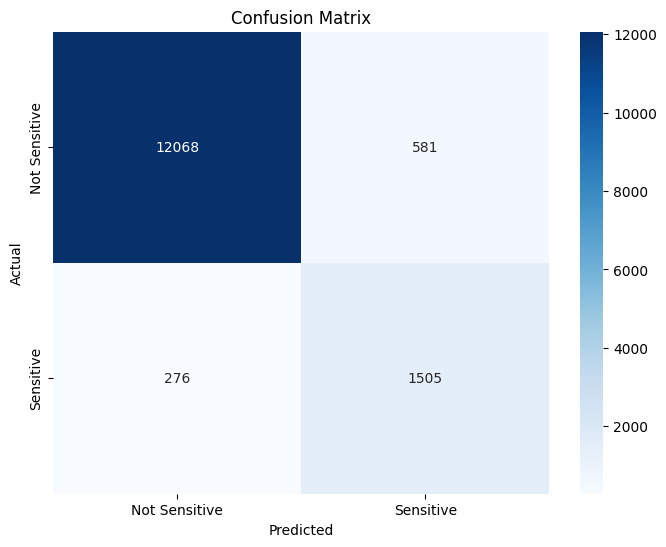

Accuracy: 0.9406
Precision: 0.7215
Recall: 0.8450
F1-score: 0.7784
F2-score: 0.8170


In [132]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import fbeta_score

y_pred_test = predict_labels(x_test=X_test, df_combined=df_combined)

cm2 = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Sensitive', 'Sensitive'],
            yticklabels=['Not Sensitive', 'Sensitive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

accuracy_2 = accuracy_score(y_test, y_pred_test)
precision_2 = precision_score(y_test, y_pred_test)
recall_2 = recall_score(y_test, y_pred_test)
f1_2 = f1_score(y_test, y_pred_test)
f2_2 = fbeta_score(y_test, y_pred_test, beta=2)


print(f"Accuracy: {accuracy_2:.4f}")
print(f"Precision: {precision_2:.4f}")
print(f"Recall: {recall_2:.4f}") # sensitivity
print(f"F1-score: {f1_2:.4f}")
print(f"F2-score: {f2_2:.4f}")

## Export Results with predicted labels

In [141]:
output_df = test
merge_on = "sequential identifier" 
output_df[merge_on] = output_df[merge_on].astype(int)
df_combined_output = df_combined[[merge_on, "predicted_sensitivity_combined" ]]
output_df = output_df.merge(df_combined_output)

output_df.head()
output_df.to_csv("combined_approach_test_predicted.csv")

/var/folders/yq/7prx38690sv9q36q0t8x_4x00000gn/T/ipykernel_21377/658988482.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df[merge_on] = output_df[merge_on].astype(int)
